# CAICT 風機結冰預測 - DNNAutoencoder c3

2017/07/21   
徐仕杰

## Outline

-  [1. Load Data and Module](#load) 
-  [2. Modeling - Autoencoder and Classification](#Modeling)  
-  [3. Training](#Training)
-  [4. Assessment](#Assessment)


### Summary
Data: 
- Autoencoer model Training Data: $\color{blue}{使用15號風機的異常資料與異常前後的正常資料}$  
- Classification model Training Data: 使用15號風機 event#1 ~ event#20 的異常資料與異常前後的正常資料  
- Classification model Validataion Data: 使用15號風機 event#21 ~ event#24 的異常資料與異常前後的正常資料 
- Classification model Testing#1 Data: 使用21號風機的異常資料與異常前後的正常資料 
- Classification model Testing#2 Data: 使用21號風機的完整資料

Model:   
- Autoencoder: DNN  
    - Encoder  
      - input: 26  
      - 26 x 19  
      - 19 x 13   
      - 13 x 7  
    - Decoder  
      - 7 x 13  
      - 13 x 19  
      - 19 x 26    
      
- Classification: Logistic regression  
    - Classification 
      - input: 13 x 7 (encoder)
      - 26 x 2  
      - output: 2  
   
Result: 全部都預測異常
- Training data set:
   > score 0.5 OrderedDict([('tn', 0), ('fn', 0), ('tp', 22179), ('fp', 35339)])
        Accuracy: 0.614399
        Precision 0.385601029243
        Recall 1.0
- Validataion data set: 
    > score 0.5 OrderedDict([('tn', 0), ('fn', 0), ('tp', 4315), ('fp', 7680)])
        Accuracy: 0.640267
        Precision 0.359733222176
        Recall 1.0

- Testing#1 data set
    > score 0.5 OrderedDict([('tn', 0), ('fn', 0), ('tp', 11988), ('fp', 19387)])
        Accuracy: 0.617912
        Precision 0.382087649402
        Recall 1.0
        
- Testing#2 data set
    > score 0.5 {'tn': 0, 'fn': 0, 'fp': 168930, 'tp': 10638}
        Accuracy: 0.940757
        Precision 0.059242181235
        Recall 1.0


Tensorboard folder: conodition2        

<a id='load'></a>
## 1. Load Data and Module

In [31]:
import pandas as pd
import os
import sys
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import shutil
import matplotlib.pyplot as plt
import shutil
import csv
import sklearn as sk
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import precision_score
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from collections import OrderedDict

In [39]:
def variable_summaries(var, name):  
    with tf.name_scope('summaries_'+str(name)):  
        mean = tf.reduce_mean(var)  
        tf.summary.scalar('mean', mean)  
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))  
        tf.summary.scalar('stddev', stddev)  
        tf.summary.scalar('max', tf.reduce_max(var))  
        tf.summary.scalar('min', tf.reduce_min(var))  
        tf.summary.histogram('histogram', var)  
        
def updateProgress(msg):
    sys.stdout.write('\r')
    sys.stdout.write(msg)
    sys.stdout.flush()
    
def myscore(true_y, pred_y):
    n,p =sk.metrics.confusion_matrix(true_y, pred_y)
    tn = n[0]
    fp = n[1]
    fn = p[0]
    tp = p[1]
    score = 1- 0.5*(fp/(tn+fp))- 0.5*(fn/(fn+tp)) 
    confusions = (
    ('tn', tn),
    ('fn', fn),
    ('tp', tp),
    ('fp', fp)
    )
    return score, OrderedDict(confusions)



In [3]:
def variable_selection(data, isTest=False):
    if isTest:
        fixed_variable = ['time','group']
    else:
        fixed_variable = ['label','event','time','group','timestamp']
    #selected_variable = ['pitch1_angle','pitch2_angle','pitch3_angle','pitch1_speed','pitch3_speed','pitch2_speed']
    selected_variable = ['pitch1_angle','pitch2_angle','pitch3_angle','pitch1_speed','pitch3_speed','pitch2_speed','power','yaw_position','environment_tmp']
    variable = selected_variable + fixed_variable 
    data = data[variable]
    return data

def load_resample_data(id, remove_unknown=True, split_case=20, split_validation=True, policy=1, varsel=False, label=None):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    if varsel:
        data_resample=variable_selection(data_resample)
    
    if remove_unknown:
        data_resample = data_resample[data_resample['label']!=2]
    
    if label is not None:
        data_resample = data_resample[data_resample['label']==label]
    
    data_resample_train = data_resample[data_resample['event']<split_case]
    data_resample_valid = data_resample[data_resample['event']>=split_case]

    train_aX = data_resample.drop(['label','time','group','timestamp','event'], axis=1).values
    train_ay = data_resample['label'].values.astype(int)
    train_aY = np.eye(2)[train_ay]
    
    train_X = data_resample_train.drop(['label','time','group','timestamp','event'], axis=1).values
    train_y = data_resample_train['label'].values.astype(int)
    valid_X = data_resample_valid.drop(['label','time','group','timestamp','event'], axis=1).values
    valid_y = data_resample_valid['label'].values.astype(int)
    train_Y = np.eye(2)[train_y]
    valid_Y = np.eye(2)[valid_y]

    train_abnormal = data_resample_train[data_resample_train['label']==1]
    train_normal = data_resample_train[data_resample_train['label']==0]
    train_desc = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(train_normal), j=len(train_normal)/len(data_resample_train),k=len(train_abnormal),m=len(train_abnormal)/len(data_resample_train), n=len(data_resample_train))
    
    valid_abnormal = data_resample_valid[data_resample_valid['label']==1]
    valid_normal = data_resample_valid[data_resample_valid['label']==0]
    valid_desc = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(valid_normal), j=len(valid_normal)/len(data_resample_valid),k=len(valid_abnormal),m=len(valid_abnormal)/len(data_resample_valid), n=len(data_resample_valid))
    if split_validation:
        return data_resample, train_X, train_Y, train_y, valid_X, valid_Y, valid_y, train_desc, valid_desc
    else:
        return data_resample, train_aX, train_aY, train_ay

def load_test1_data(id,remove_unknown=True, dropna=True, varsel=False):
    filename = 'data/goodformat_{ID}.csv'.format(ID=id)
    data_raw = pd.read_csv(filename)
    if varsel:
        data_raw=variable_selection(data_raw)
        
    if dropna:
        data_raw = data_raw.dropna()
    else: 
        data_raw = data_raw.fillna(0)
        
    data_X = data_raw.drop(['label','time','group','timestamp'], axis=1).values
    data_y = data_raw['label'].values.astype(int)
    data_Y = np.eye(2)[data_y]
    
    data_abnormal = data_raw[data_raw['label']==1]
    data_normal = data_raw[data_raw['label']==0]
    data_desc = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(data_normal), j=len(data_normal)/len(data_raw),k=len(data_abnormal),m=len(data_abnormal)/len(data_raw), n=len(data_raw))
    
    return data_raw, data_X, data_Y, data_y, data_desc

def load_test2_data(varsel=False):
    test_data = pd.read_csv('data/ice1/test/08/08_data.csv')
    if varsel:
        test_data=variable_selection(test_data,isTest=True)
    test_timeidx = test_data['time']
    tmp = test_data.drop(['time','group'], axis=1)
    test_X = tmp.values
    return test_data, test_X, test_timeidx


**Load input data.** 

In [4]:
#Data for autoencoder 
policy=1
_, train_auto_X, _, train_auto_y = load_resample_data(id=15,policy=policy,split_validation=False,split_case=8,varsel=False,label=None)


In [5]:
len(train_auto_X)

69513

In [6]:
#data for classification
policy=1
train_raw, train_X, train_Y, train_y, valid_X, valid_Y, valid_y, train_desc, valid_desc = load_resample_data(id=15,policy=policy,varsel=False)
valid_raw, valid_21_X, valid_21_Y, valid_21_y= load_resample_data(id=21,policy=policy,split_validation=False,split_case=8,varsel=False)
test_raw, test_X,test_timeidx = load_test2_data(varsel=False)

In [7]:
print('15-valid:', train_desc)
print('15-train:',valid_desc)

15-valid: 正常:35339 (0.61 percent), 結冰:22179 (0.39 percent), Total:57518
15-train: 正常:7680 (0.64 percent), 結冰:4315 (0.36 percent), Total:11995


<a id='Modeling'></a>
## 2. Modeling


** 定義參數- Autoencoder **    

In [8]:
n_inputs = len(train_X[1]) # 每一行的维度
n_classes = len(train_Y[1])  # RNN最后的输出類別個数
encoded_neural = 7
print('n_inputs:',n_inputs)
print('n_classes:',n_classes)
print('encoded_dim:',encoded_neural)

tf.reset_default_graph()
X =tf.placeholder(tf.float32, [None, n_inputs], name="X")
        
W = {
    'enc_wd1': tf.Variable(tf.truncated_normal(shape =[n_inputs,19], stddev=0.01), name="enc_wd1"),
    'enc_wd2': tf.Variable(tf.truncated_normal(shape = [19,13], stddev=0.01), name="enc_wd2"),
    'enc_wd3': tf.Variable(tf.truncated_normal(shape =[13,encoded_neural], stddev=0.01), name="enc_wd3"),
    'dec_wd1': tf.Variable(tf.truncated_normal(shape =[encoded_neural,13], stddev=0.01), name="dec_wd1"),
    'dec_wd2': tf.Variable(tf.truncated_normal(shape =[13,19], stddev=0.01), name="dec_wd2"),
    'dec_wd3': tf.Variable(tf.truncated_normal(shape =[19,n_inputs], stddev=0.01), name="dec_wd3"),
}

B = {
    'enc_bd1': tf.Variable(tf.truncated_normal(shape =[19]),name="enc_bd1"),
    'enc_bd2': tf.Variable(tf.truncated_normal(shape =[13]), name="enc_bd2"),
    'enc_bd3': tf.Variable(tf.truncated_normal(shape =[encoded_neural]), name="enc_bd2"),
    'dec_bd1': tf.Variable(tf.truncated_normal(shape =[13]), name="dec_bd1"),
    'dec_bd2': tf.Variable(tf.truncated_normal(shape =[19]),name="dec_bd2"),
    'dec_bd3': tf.Variable(tf.truncated_normal(shape =[n_inputs]), name="dec_bd3"),
}


n_inputs: 26
n_classes: 2
encoded_dim: 7


** 定義參數- classification **    

In [9]:
Y_ = tf.placeholder(tf.float32, shape=[None, n_classes], name="Y_")
W2 = {
    'cla_wd1': tf.Variable(tf.truncated_normal(shape =[encoded_neural,n_classes], stddev=0.01), name="cla_wd1"),
}
B2 = {
    'cla_bd1': tf.Variable(tf.truncated_normal(shape =[n_classes]),name="cla_bd1"),
}
trainable_vars = [W2['cla_wd1'],B2['cla_bd1']]

** 網路結構 - Autoencoder **

** Encoder layer **

In [10]:
with tf.name_scope("Encoder_Layer"):
    H1 = tf.matmul(X, W['enc_wd1']) + B['enc_bd1'] 
    H1 = tf.nn.sigmoid(H1, name="H1")
    H2 = tf.matmul(H1, W['enc_wd2']) + B['enc_bd2'] 
    H2 = tf.nn.relu(H2, name="H2")
    encoded = tf.matmul(H2, W['enc_wd3']) + B['enc_bd3'] 
    encoded = tf.nn.sigmoid(encoded, name="encoded")

** Decoder layer **

In [11]:
with tf.name_scope("Decoder_Layer"):
    H10 = tf.matmul(encoded, W['dec_wd1']) + B['dec_bd1'] 
    H10 = tf.nn.sigmoid(H10, name="H10")
    H11 = tf.matmul(H10, W['dec_wd2']) + B['dec_bd2'] 
    H11 = tf.nn.relu(H11, name="H11")
    decoded = tf.matmul(H11, W['dec_wd3']) + B['dec_bd3'] 
    decoded = tf.nn.sigmoid(decoded, name="decoded")

** Classification Layer **

In [12]:
with tf.name_scope("Output_Layer"):
    _pred = tf.matmul(encoded, W2['cla_wd1']) + B2['cla_bd1']
    pred = tf.nn.softmax(_pred, name="pred")
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


with tf.name_scope("Output_Layer"):
    Y= tf.add(x= tf.matmul(encoded, W2['cla_wd1'], name='e'), y=B2['cla_bd1'], name='Y')
    Y_softmax = tf.nn.softmax(Y, name='Y_softmax') #這個是one-hot的格式
    Y_softmax_argmax = tf.argmax(Y_softmax, axis=1) #從one-hot的格式找出最大那個
    
    correct_prediction = tf.equal(Y_softmax_argmax, tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    #acc_scar = tf.summary.scalar('accuracy', accuracy)



** Loss Function & Optimizer - Autoencoder**

loss_auto = tf.reduce_mean(-tf.reduce_sum(X*tf.log(decoded), axis=1))
#loss_scar = tf.summary.scalar('loss', loss)
optimizer_auto = tf.train.RMSPropOptimizer(0.01).minimize(loss_auto)

In [13]:
#cross_entropy = -1. * X * tf.log(decoded) - (1. - X) * tf.log(1. - decoded)
#loss_auto = tf.reduce_mean(cross_entropy)
#loss_auto = tf.reduce_mean(tf.pow(decoded - X, 2))
#loss_auto = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=decoded, labels=X))

#loss_auto = - tf.reduce_mean(X * tf.log(decoded))
loss_auto = tf.sqrt(tf.reduce_mean(tf.square(X - decoded)))
optimizer_auto = tf.train.RMSPropOptimizer(0.01).minimize(loss_auto)

In [14]:

#self.cost = tf.sqrt(tf.reduce_mean(tf.square(self.input_data - self.decode)))


** Loss Function & Optimizer- Classification **

In [15]:
loss_cla = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_, logits=_pred))
optimizer_cla = tf.train.RMSPropOptimizer(0.01).minimize(loss_cla,var_list=trainable_vars)

<a id='Training'></a>
## 3. Training  

** Training - Autoencoder **

In [16]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

In [17]:
epoch = 15
batch_size = 3000
total_batch= len(train_auto_X) / batch_size
for ep in range(epoch+1):
    for i in range(int(total_batch)+1):
        rnd_idx = np.random.choice(train_auto_X.shape[0], batch_size, replace=False)
        batch_x = train_auto_X[rnd_idx]
        _, loss_v= sess.run([optimizer_auto, loss_auto], feed_dict={X: batch_x})
        
    updateProgress('epoch:{x0}, batch:{x4} loss:{x3}'.format(x0=ep,x3=loss_v,x4=i))
    print()
    


epoch:0, batch:23 loss:1.0901755094528198
epoch:1, batch:23 loss:1.0702117681503296
epoch:2, batch:23 loss:1.0046156644821167
epoch:3, batch:23 loss:0.9079899191856384
epoch:4, batch:23 loss:0.8884467482566833
epoch:5, batch:23 loss:0.8899254202842712
epoch:6, batch:23 loss:0.8912538886070251
epoch:7, batch:23 loss:0.8935824632644653
epoch:8, batch:23 loss:0.8996637463569641
epoch:9, batch:23 loss:0.8922008872032166
epoch:10, batch:23 loss:0.8892185688018799
epoch:11, batch:23 loss:0.8939404487609863
epoch:12, batch:23 loss:0.8969378471374512
epoch:13, batch:23 loss:0.8968066573143005
epoch:14, batch:23 loss:0.8886265754699707
epoch:15, batch:23 loss:0.889778196811676


**  Training - Classification **

In [18]:
epoch = 15
batch_size = 256
total_batch= len(train_X) / batch_size
for ep in range(epoch+1):
    for i in range(int(total_batch)+1):
        rnd_idx = np.random.choice(train_X.shape[0], batch_size, replace=False)
        batch_x = train_X[rnd_idx]
        batch_y = train_Y[rnd_idx]
        _, loss_v, acc_v= sess.run([optimizer_cla, loss_cla, accuracy], feed_dict={X: batch_x, Y_:batch_y})
        
    loss_v2, acc_v2= sess.run([loss_cla, accuracy], feed_dict={X: valid_X , Y_: valid_Y})
    updateProgress('Ep:{x0}, Bch:{x4}, Tr: loss:{x5}, acc:{x6}, Vd: loss:{x3}, acc:{x2}'.format(x0=ep,x1=i,x2=acc_v2,x3=loss_v2,x4=i,x6=acc_v,x5=loss_v))
    print()




Ep:0, Bch:224, Tr: loss:0.6574543714523315, acc:0.6328125, Vd: loss:0.6533530950546265, acc:0.6402665376663208
Ep:1, Bch:224, Tr: loss:0.6627974510192871, acc:0.625, Vd: loss:0.6549326181411743, acc:0.6402665972709656
Ep:2, Bch:224, Tr: loss:0.6757967472076416, acc:0.59375, Vd: loss:0.6568994522094727, acc:0.6402665376663208
Ep:3, Bch:224, Tr: loss:0.6605463624000549, acc:0.640625, Vd: loss:0.6552566289901733, acc:0.6402665972709656
Ep:4, Bch:224, Tr: loss:0.6788945198059082, acc:0.5859375, Vd: loss:0.6575201749801636, acc:0.6402665376663208
Ep:5, Bch:224, Tr: loss:0.6843823194503784, acc:0.578125, Vd: loss:0.6566252112388611, acc:0.6402665972709656
Ep:6, Bch:224, Tr: loss:0.661266028881073, acc:0.62890625, Vd: loss:0.6543930768966675, acc:0.6402665376663208
Ep:7, Bch:224, Tr: loss:0.6659154295921326, acc:0.6171875, Vd: loss:0.6550809144973755, acc:0.6402665972709656
Ep:8, Bch:224, Tr: loss:0.6463800668716431, acc:0.6640625, Vd: loss:0.6534305214881897, acc:0.6402665376663208
Ep:9, Bch

<a id='Assessment'></a>
## 4. Assessment

In [19]:
threshold=0.18

** Predict Training Data **

In [40]:
acc_t = accuracy.eval({X: train_X , Y_: train_Y})
pred_t = pd.DataFrame(pred.eval({X: train_X}))
#pred_t = pred_t.apply(np.argmax,axis=1)
pred_failprop = pred_t[1]
pred_result = pred_failprop.copy()

pred_result[pred_result >threshold] = 1
pred_result[pred_result <=threshold] = 0

pd.Series(train_y).value_counts()
pred_result.value_counts()

s,_=myscore(train_y, pred_result)

print('score',s,_)
print('\tAccuracy:',acc_t)
print("\tPrecision", precision_score(train_y, pred_result))
print("\tRecall", sk.metrics.recall_score(train_y, pred_result))




score 0.5 OrderedDict([('tn', 0), ('fn', 0), ('tp', 22179), ('fp', 35339)])
	Accuracy: 0.614399
	Precision 0.385601029243
	Recall 1.0


** Predict  Validataion Data **

In [41]:
# predict all X and get the accuracy
acc_v = accuracy.eval({X: valid_X , Y_: valid_Y})
pred_v = pd.DataFrame(pred.eval({X: valid_X}))
#pred_v = pred_v.apply(np.argmax,axis=1)
pred_failprop = pred_v[1]
pred_result = pred_failprop.copy()

pred_result[pred_result >threshold] = 1
pred_result[pred_result <=threshold] = 0

pred_result.value_counts()

s,_=myscore(valid_y, pred_result)

print('score',s,_)
print('\tAccuracy:',acc_v)
print("\tPrecision", precision_score(valid_y, pred_result))
print("\tRecall", sk.metrics.recall_score(valid_y, pred_result))




score 0.5 OrderedDict([('tn', 0), ('fn', 0), ('tp', 4315), ('fp', 7680)])
	Accuracy: 0.640267
	Precision 0.359733222176
	Recall 1.0


** Predict another machine - partial data**

In [42]:
# predict all X and get the accuracy
acc_t = accuracy.eval({X: valid_21_X , Y_: valid_21_Y})
pred_t = pd.DataFrame(pred.eval({X: valid_21_X}))
#pred_t = pred_t.apply(np.argmax,axis=1)
pred_failprop = pred_t[1]
pred_result = pred_failprop.copy()

pred_result[pred_result >threshold] = 1
pred_result[pred_result <=threshold] = 0

pred_result.value_counts()

s,_=myscore(valid_21_y, pred_result)

print('score',s,_)
print('\tAccuracy:',acc_t)
print("\tPrecision", precision_score(valid_21_y, pred_result))
print("\tRecall", sk.metrics.recall_score(valid_21_y, pred_result))


score 0.5 OrderedDict([('tn', 0), ('fn', 0), ('tp', 11988), ('fp', 19387)])
	Accuracy: 0.617912
	Precision 0.382087649402
	Recall 1.0


** Predict Test Data **


pred_T = pd.DataFrame(pred.eval({X: test_X}))
#pred_T = pred_T.apply(np.argmax,axis=1)
pred_failprop = pred_T[1]
pred_T_result = pred_failprop.copy()


pred_T_result[pred_T_result >threshold] = 1
pred_T_result[pred_T_result <=threshold] = 0

pred_T_result.value_counts()

startTime=0
endTIme=0
search_start=True
search_end=False
abnormal_list=[]
test_timeidx=test_timeidx.astype(int)
for i,v in enumerate(pred_T_result):
    if (v==1) & (search_start):
        startTime = test_timeidx[i]
        search_end=True
        search_start=False
    if (v==0) & (search_end):
        endTIme=test_timeidx[i]
        search_start=True
        search_end=False
        abnormal_list.append((startTime,test_timeidx[i-1]))
print(len(abnormal_list))
abnormal_list[:10]



output_ans=True
if(output_ans):
    with open('test1_08_results.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['startTime','endTime'])
        for row in abnormal_list:
            dummy = csv_out.writerow(row)

print('done')



### Find the best threshold from ROC/AUC

In [23]:
test_raw_N, test_N_X, test_N_Y, test_N_y= load_resample_data(id=21,policy=0,split_validation=False,split_case=8,varsel=False)
data_target = test_raw_N.copy()
len(test_N_X)

179568

In [24]:
pred_t = pd.DataFrame(pred.eval({X: test_N_X}))
pred_t_sm = pred_t.apply(np.argmax,axis=1)

pred_failprop = pred_t[1]


AUC: 0.297233618782


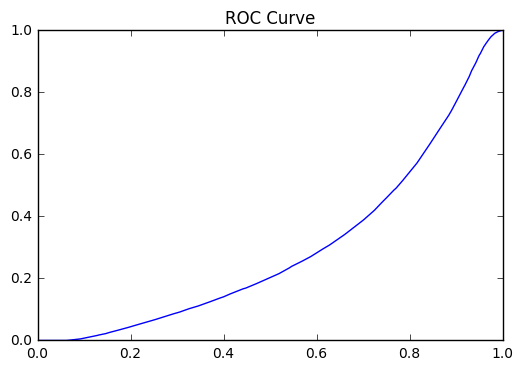

In [25]:
true_labels =data_target['label'].copy().values 
true_labels[true_labels ==2] = 0
fpr, tpr, thresholds = roc_curve(true_labels, pred_failprop)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1) 
plt.title('ROC Curve')
print('AUC:',roc_auc)
plt.show()
roc_df = pd.DataFrame({'thresholds':thresholds, 'fpr':fpr,'tpr':tpr})
roc_df = roc_df[roc_df['tpr']>0.8][:10]

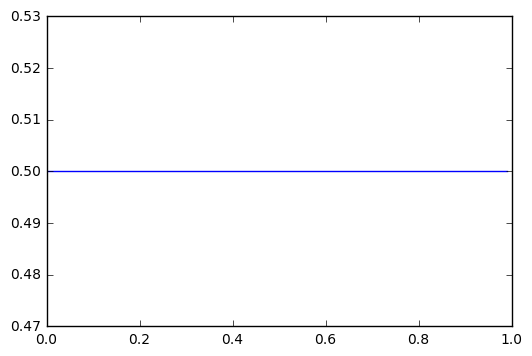

best_x: 0.0
best_score: 0.5


In [29]:
x_tmp = np.arange(0., 1, 0.01)
y_tmp=[]
for threshold in x_tmp:
    pred_prob_tmp = pred_failprop.copy()
    pred_prob_tmp[pred_prob_tmp >threshold] = 1
    pred_prob_tmp[pred_prob_tmp <=threshold] = 0
    s,_=myscore(true_labels, pred_prob_tmp)
    y_tmp.append(s)
    del pred_prob_tmp

plt.plot(x_tmp, y_tmp) 
plt.show()
best_idx = np.argmax(y_tmp)
best_x = x_tmp[best_idx]
best_y = y_tmp[best_idx]
print('best_x:',best_x)
print('best_score:',best_y)

In [30]:
acc_t2 = accuracy.eval({X: test_N_X , Y_: test_N_Y})
threshold = best_x
pred_prob_tmp = pred_failprop.copy()
pred_prob_tmp[pred_prob_tmp >threshold] = 1
pred_prob_tmp[pred_prob_tmp <=threshold] = 0
s,_=myscore(true_labels, pred_prob_tmp)


print('score',s,_)
print('\tAccuracy:',acc_t2)
print("\tPrecision", precision_score(true_labels, pred_prob_tmp))
print("\tRecall", sk.metrics.recall_score(true_labels, pred_prob_tmp))

score 0.5 {'tn': 0, 'fn': 0, 'fp': 168930, 'tp': 10638}
	Accuracy: 0.940757
	Precision 0.059242181235
	Recall 1.0


### Tensor Borad

In [28]:
LOG_DIR = 'tb-log/condition2'
input_data = train_X
input_y = train_y
if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
#把圖片的label存到metadata.tsv
metadata_file_path = os.path.join(LOG_DIR, 'metadata.tsv')
with open(metadata_file_path, 'w') as metadata_file:
    for row in range(len(input_y)):
        c=input_y[row]
        metadata_file.write('{}\n'.format(c))

FileNotFoundError: [WinError 3] 系統找不到指定的路徑。: 'tb-log/condition2'

In [ ]:
#Save variable
Input_Var = tf.Variable(input_data, name='Input_var')
H1_Var = tf.Variable(H1.eval({X: input_data}), name='H1_var')
H2_Var = tf.Variable(H2.eval({X: input_data}), name='H2_Var')
H10_Var = tf.Variable(H10.eval({X: input_data}), name='H10_var')
H11_Var = tf.Variable(H11.eval({X: input_data}), name='H11_Var')
encoded_Var = tf.Variable(encoded.eval({X: input_data}), name='encoded_var')
decoded_Var = tf.Variable(decoded.eval({X: input_data}), name='decoded_Var')

saver = tf.train.Saver([Input_Var,encoded_Var,decoded_Var,H1_Var,H2_Var,H10_Var,H11_Var])
sess.run(Input_Var.initializer)
sess.run(encoded_Var.initializer)
sess.run(decoded_Var.initializer)
sess.run(H1_Var.initializer)
sess.run(H2_Var.initializer)
sess.run(H10_Var.initializer)
sess.run(H11_Var.initializer)

saver.save(sess, os.path.join(LOG_DIR, 'autoencoder.ckpt'))

#在config裡面用一個embedding關聯 tensor & its metadata
config = projector.ProjectorConfig()
# One can add multiple embeddings.

embedding1 = config.embeddings.add()
embedding1.tensor_name = Input_Var.name
embedding1.metadata_path = metadata_file_path

embedding2 = config.embeddings.add()
embedding2.tensor_name = encoded_Var.name
embedding2.metadata_path = metadata_file_path

embedding3 = config.embeddings.add()
embedding3.tensor_name = decoded_Var.name
embedding3.metadata_path = metadata_file_path

embedding4 = config.embeddings.add()
embedding4.tensor_name = H1_Var.name
embedding4.metadata_path = metadata_file_path

embedding4 = config.embeddings.add()
embedding4.tensor_name = H2_Var.name
embedding4.metadata_path = metadata_file_path

embedding4 = config.embeddings.add()
embedding4.tensor_name = H10_Var.name
embedding4.metadata_path = metadata_file_path

embedding4 = config.embeddings.add()
embedding4.tensor_name = H11_Var.name
embedding4.metadata_path = metadata_file_path

#embedding.sprite.image_path = os.path.join(LOG_DIR, 'img/mnist_10k_sprite.png')
# Specify the width and height of a single thumbnail.
#embedding.sprite.single_image_dim.extend([28, 28])



# Saves a config file that TensorBoard will read during startup.
projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)


In [ ]:
#!tensorboard --logdir=tb-log0 --port=6006